In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table... (create variable)
M = base.classes.measurement
S = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
#cell3 line 4
#check to see if connected to DB
session = Session(engine)  

# Exploratory Precipitation Analysis

In [9]:
# finding all dates
#session.query(M.date).all()

#3 ways to find most recent date set
#session.query(func.max(M.date)).first()
session.query(M.date).order_by(M.date.desc()).first()

('2017-08-23',)

In [10]:
# Find the most recent date in the data set.
dateStr = session.query(M.date).all()[-1][0]

In [11]:
#turn string into date
lastDate = dt.datetime.strptime(dateStr, '%Y-%m-%d').date()

#prev year
prevYear= lastDate-dt.timedelta(365)
prevYear

datetime.date(2016, 8, 23)

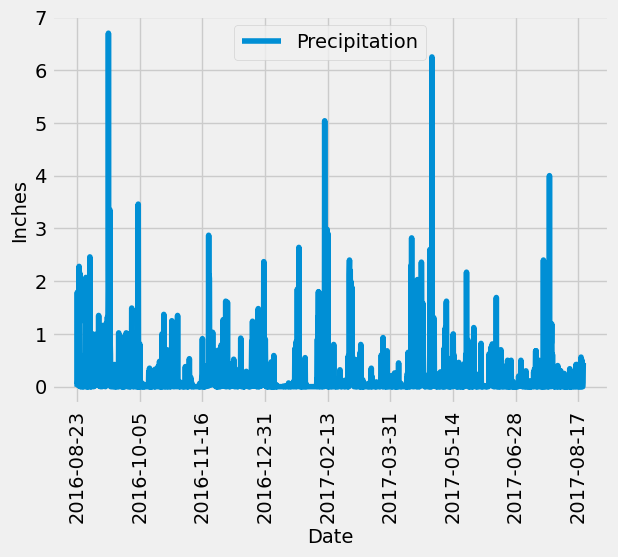

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(M.date).order_by(M.date.desc()).first()

# Calculate the date one year from the last date in data set.
lastDate = dt.datetime.strptime(dateStr, '%Y-%m-%d').date()
prevYear= lastDate-dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(M.date, M.prcp).filter(M.date>=prevYear).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results,columns=['Date','Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date').set_index('Date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90,ylabel='Inches');

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(S.id)).all()
total_stations


[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(M.station, func.count(M.station)).\
                            group_by(M.station).\
                            order_by(sqlalchemy.desc(func.count(M.station))).all()
# List the stations and their counts in descending order.
result_list = [(station, count) for station, count in active_stations]
result_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = 'USC00519281'

result = session.query(func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs)).\
                filter(M.station == most_active).all()

result_list = [result[0]]
result_list

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')


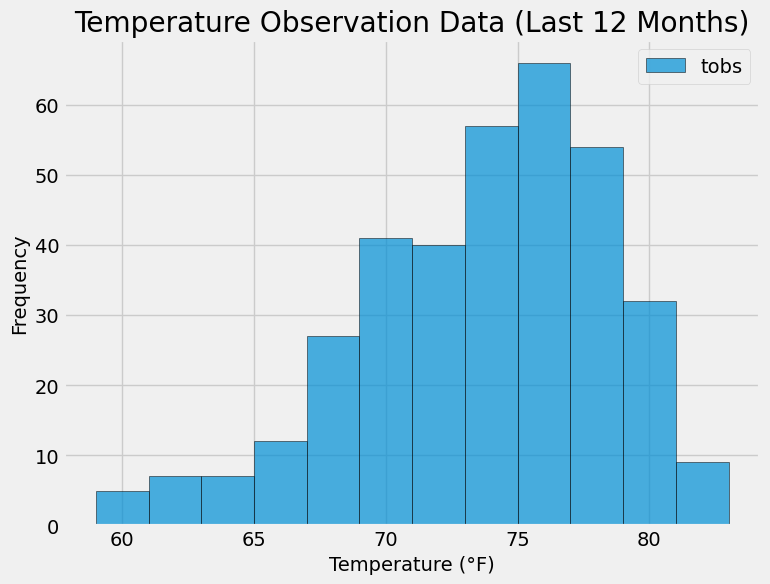

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# most_active = 'USC00519281'


# Need to convert last_date to datetime object
last_date = session.query(func.max(M.date)).filter(M.station == most_active).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()

# Calculating the previous 12 months
prev_twelve = last_date - dt.timedelta(days=365)

# temps for the most active id for the previous 12 months
results = session.query(M.tobs).filter(M.station == most_active, M.date >= prev_twelve).all()

# Isolate the temps
temperatures = [result[0] for result in results]
print("Text(0.5, 4.183333333333314, 'Temperature')")


# # Plot
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.grid(True)
plt.legend()
plt.show()



# Close Session

In [18]:
# Close Session
session.close()